# Import

In [16]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import pickle, json
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
from utils import *
from utils_test import *
from datas import *
from models.Decoder_only import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

stock_symbol = '5871.TW'
end_date = '2024-12-31'

num_class = 2
batch_size = 128
init = True
fp16_training = True
num_epochs = 200
lr = 0.0001

# Strategy
short = False

# Model
MODEL = "Decoder-only"
model = TransformerDecoderOnly(num_class=num_class).to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loss Result

In [17]:
with open(f'Temp/{MODEL}_class{num_class}_{stock_symbol}_LastTrainInfo.pk', 'rb') as f:
    infos = pickle.load(f)
    print(infos['min val loss'])
with open(f'Model_Result/{MODEL}_min_loss.json', 'a') as file:
    json.dump({f'{MODEL}_class{num_class}_{stock_symbol}': infos['min val loss']}, file)
    file.write('\n')
    


1.5207993984222412


### Data

In [18]:
# Data
trainloader, validloader, testloader, test_date, df, src = data()

src = src.permute(0, 2, 1).to(device)
x_valid = [x for x, y in validloader]
x_valid = torch.cat(x_valid, dim = 0)
for x, y in testloader:
    print(x.shape)
    break

x_train_len: 2847, valid_len: 149, test_len: 157
torch.Size([64, 6, 10])


### Backtest 

In [19]:
def backtest_plot(normalise=False):
    # Prediction
    model.load_state_dict(torch.load(f'Model_Result/{MODEL}_class{num_class}_{stock_symbol}_best_model.pt'))
    model.eval()    
    y_pred, acc = test_encoder(model, testloader)
    y_train_pred, acc = test_encoder(model, validloader)
    y_pred_numpy = y_pred.cpu().numpy()
    prediction = pd.DataFrame(y_pred_numpy)
        
    # Scaling with predicted valid set
    if normalise:
        y_train_numpy = y_train_pred.detach().cpu().numpy()
        scaler = StandardScaler()
        scaler.fit(y_train_numpy)
        prediction = pd.DataFrame(scaler.transform(prediction))
    
    # Column name
    if num_class == 1:
        prediction.columns = ['pred_doc_1']
    else:
        prediction.columns = ['pred_do_1', 'pred_dc_1']

    # Merge on date. 
    prediction['Date'] = test_date[:len(prediction)]
    true_and_pred = pd.merge(df.reset_index(), prediction, on = 'Date', how = 'left')
    true_and_pred['Close'] = true_and_pred['Close_origin']
    
    """
    NOTE:
    1. Use today's data predict tmr's
    2. y is y * 100. /= 100 here
    3. d~ is all percentile change
    """
    if num_class == 2:
        true_and_pred['pred_o'] = (true_and_pred['Open'] * (1 + true_and_pred['pred_do_1']/100))
        true_and_pred['pred_c'] = (true_and_pred['Close'] * (1 + true_and_pred['pred_dc_1']/100))
        true_and_pred['pred_doc_1'] = \
            (true_and_pred['pred_c'] - true_and_pred['pred_o'])/true_and_pred['pred_o']
    elif num_class == 1:
        true_and_pred['pred_doc_1'] /= 100
    true_and_pred['doc_1'] /= 100
    
    # Backtest
    """
    NOTE:
    For encoder-only and encoder-decoder since the second one need to drop last, 
    buy hold would not be the same
    """
    asset_list = []
    if num_class == 2:
        df_backtest = true_and_pred[['Open', 'Close', 'doc_1', 'pred_doc_1', 'pred_do_1', 'pred_dc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (o, c, true, pred, _, _) in df_backtest.iterrows():
            if pred > 0.004:
                asset *= (1 + true)   
            if short and pred < -0.004:
                asset *= (1 - true)   
            asset_buyhold *= (1 + true)
            asset_list.append(asset)
        # print(f'Buy Hold last asset: {asset_buyhold}')
    else:
        df_backtest = true_and_pred[['Close', 'pred_doc_1', 'doc_1']].dropna()
        acc = (np.sign(df_backtest['pred_doc_1'])==np.sign(df_backtest['doc_1'])).sum()/len(df_backtest)
        asset = 1
        asset_buyhold = 1
        for index, (c, pred, true) in df_backtest.iterrows():
            # print(pred, true)
            if pred > 0.004:
                asset *= (1 + true)
            if short and pred < -0.004:
                asset *= (1 - true)
            asset_buyhold *= (1 + true)
            asset_list.append(asset)

    print(f'Asset: {asset}')
    plt.plot(asset_list, label = 'model')
    plt.plot(df_backtest.reset_index()['Close']/df_backtest['Close'].iloc[0], label = 'buy hold')
    plt.legend()
    return y_pred, df_backtest

100%|██████████| 2/2 [00:00<00:00, 19.12it/s]


Asset: 0.9295022456267484


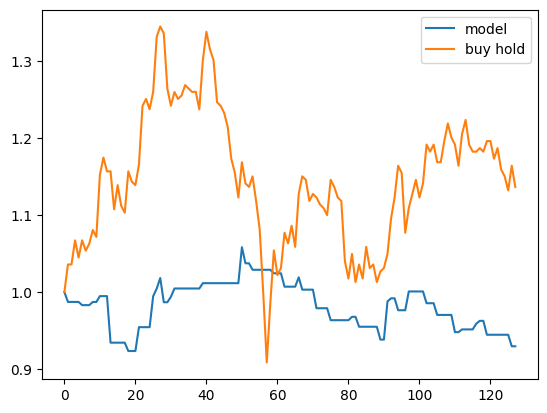

In [20]:
y_pred, df_b = backtest_plot()
plt.savefig(f'Model_Result/{MODEL}_class{num_class}_{stock_symbol.split(".")[0]}_backtest')
torch.cuda.empty_cache()
    